# 삽관/발관 데이터 페어링하고 환자군 분류

### Subjectlist DATA (고유한 환자들의 입원기록만 있는 테이블) - (7231, 5)
- subject_id: 환자 고유번호 (출처: hosp_patients)
- hadm_id: 병원 입원 고유번호 (출처: hosp_admissions)
- stay_id: 중환자실 입원 고유번호. 발관 시간 기준으로 생성. 발관시간 NULL일 경우 삽관 이벤트 활용 (출처: icu_icustays)
- admittime: 입원시각 (출처: hosp_admissions)
- dischtime: 퇴원시각 (출처: hosp_admissions)

### Intubation/Extubation DATA (삽관 발관 시간 데이터 포함된 테이블) - (9003, 29)
- subject_id: 환자 고유번호 (출처: hosp_patients)
- hadm_id: 병원 입원 고유번호 (출처: hosp_admissions)
- stay_id: 중환자실 입원 고유번호. 발관 시간 기준으로 생성. 발관시간 NULL일 경우 삽관 이벤트 활용 (출처: icu_icustays)
- gender: 성별
- los: Length of Stay (days)
- int_stayid: 삽관 당시 응급병동 입원 고유번호 (출처: icu_icustays)
- admittime: 입원시각 (출처: hosp_admissions)
- intubationtime: 삽관시각 (출처: icu_procedureevents)
- int_itemid: 삽관 아이템 코드 (itemid: 224385) (출처: icu_procedureevents)
- int_weight: 삽관 당시 체중 (출처: icu_procedureevents)
- ext_stayid: 발관 당시 응급병동 입원 고유번호 (출처: icu_icustays) (출처: icu_procedureevents)
- extubationtime: 발관시각 (출처: icu_procedureevents) (출처: icu_procedureevents)
- ext_itemid: 발관 아이템 코드 (itemid: 225468, 225477, 227194) (출처: icu_procedureevents)
- ext_weight: 발관 당시 체중 (출처: icu_procedureevents)
- extubationcause: 발관 사유 (Planned Extubation, Unplanned Extubation (patient-initiated), Unplanned Extubation (patient-uninitiated)) (출처: icu_procedureevents)
- dischtime: 퇴원시각 (출처: hosp_admissions)
- deathtime: 사망시각 (출처: hosp_admissions)
- marker: 결측값 대체가 이루어진 경우 기록 (예: 퇴원시각으로 대체 시 'dischtime imputation)
- seq_num: 삽관-발관 이벤트의 시퀀스 순서(1~n)
- reint_marker (boolean): 이 환자의 입원기록에서 재삽관 존재 시 True. 
- intext_duration: 삽관시각과 발관시각의 시간차 (단위: 분)
- reintubation_eventtime: 다음 재삽관 시간 (없을 경우 NULL)
- reintubationtime: 발관 후 재삽관까지 걸린 시간 (단위: 분)
- mvtime (boolean): intext_duration이 1440분 이내 (<= 24시간)이면 mechanical ventilation (True)으로 분류 
- final_event (boolean): 현재 행이 전체 시퀀스의 최종 이벤트일 경우 True. 재삽관이 없는 단일행 데이터도 True. 
- ext_to_death: 발관 후 사망까지 소요 시간 (주의: 행별로 계산된 데이터임. 최종 발관 행의 ext_to_death만을 참고해야함.)
- ext_to_disch: 발관 후 퇴원까지 소요 시간 (주의: 행별로 계산된 데이터임. 최종 발관 행의 ext_to_disch만을 참고해야함.)
- disch_to_death: 사망시각과 퇴원시각의 시간차. 사망 후 퇴원 처리된 케이스 확인필 (단위: 분)
- class_code: 케이스별로 고유한 13개 코드로 데이터를 분류 (하단 테이블 참조)
- class: class_code 기반으로 (Extubation) failure, non-failure, death의 3개 라벨로 분류함
- stayid_mismatch (boolean): 삽관과 발관 이벤트가 발생한 stay_id가 다른 경우 True로 분류.



| Class Code | Description | Outcome |
|------------|-------------|---------|
| 11 | 재삽관 없이 발관후 48시간 넘어 퇴원 | Non-failure |
| 121 | 재삽관 없이 발관후 48시간 이내 사망 | Non-failure |
| 1221 | 재삽관 없이 발관후 24시간 이내 사망 | Death |
| 1222 | 재삽관 없이 발관후 24~48시간 이내 사망 | Death |
| 211 | 48시간 이내 재삽관 | Failure |
| 212 | 48시간 너머 재삽관 | Non-failure |
| 221 | 최종 발관 이후 48시간 넘어 퇴원 | Non-failure |
| 2221 | 최종 발관 이후 48시간 이내 사망 | Non-failure |
| 22221 | 최종 발관 이후 24시간 이내 사망 | Death |
| 22222 | 최종 발관 이후 24~48시간 이내 사망 | Death |
| 998 | (null case) 현삽관-다음삽관이 48시간 이내 | Failure |
| 999 | (null case) 현발관-다음발관이 48시간 이내 | Failure |
| 9999 | (null case) Non-failure 판단 불가 | 제거 (Exclude) |

In [1]:
import pandas as pd
from dfply import *
import time
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import sys
import os
from pathlib import Path


# 현재 노트북 파일의 상위 디렉토리에 있는 src 디렉토리의 경로를 sys.path에 추가
module_path = Path('../src').resolve()
if module_path not in sys.path:
    sys.path.append(str(module_path))

# 데이터 정제 시 필요한 모듈들
import src.subjectlist_alignment.pairing as pairing   # 삽관 발관 페어링 관련 모듈
from src.subjectlist_alignment import reintubation as rnt   # 재삽관 시간 계산 관련 모듈
from src.subjectlist_alignment import imputation as imp   # 결측치 대체 관련 모듈
from src.subjectlist_alignment import subject_classification as cls
import src.utils.utils as util   # 기타 유틸리티 모듈

### 1. 데이터 준비

In [2]:
# 데이터 불러오기
adults_icu = pd.read_csv('./data/adults_icu.csv')   # 성인 환자 정보
intubation_extubation = pd.read_csv('./data/intubation_extubation.csv', \
                                    parse_dates=['intubationtime', 'extubationtime', \
                                                 'admittime', 'dischtime', 'deathtime'])   # 삽관 발관 정보
intubation_extubation = util.create_stay_id(intubation_extubation)   # stay id 만들어 넣기

ventilation = pd.read_csv('./data/ventilation.csv', parse_dates=['starttime', 'endtime'])   # 결측치 처리 위한 vent 테이블
ventilation_df = ventilation[ventilation.ventilation_status == 'InvasiveVent']   # Invasive 만 사용

print(f'adults_icu: {adults_icu.shape}')   # (73181, 13)
print(f'intubation_extubation: {intubation_extubation.shape}')   # (10992, 14)
print(f'ventilation_df: {ventilation_df.shape}')   # (34800, 5)

adults_icu: (73181, 13)
intubation_extubation: (10992, 15)
ventilation_df: (34800, 5)


In [3]:
# 성인 환자 데이터와 삽관 발관 데이터 결합

adults_icu_filtered = adults_icu.drop(columns=['admittime', 'dischtime', 'deathtime'])
joined_df = pd.merge(intubation_extubation, adults_icu_filtered, on=['subject_id', 'hadm_id', 'stay_id'], how='inner')

# 칼럼 순서 변경
final_columns = ['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'int_stayid', 'admittime', 'intubationtime',
                 'int_itemid', 'int_weight', 'ext_stayid', 'extubationtime',
                 'ext_itemid', 'ext_weight', 'extubationcause', 'dischtime',
                 'deathtime']

joined_df = joined_df[final_columns]
joined_df

,subject_id,hadm_id,stay_id,gender,los,int_stayid,admittime,intubationtime,int_itemid,int_weight,ext_stayid,extubationtime,ext_itemid,ext_weight,extubationcause,dischtime,deathtime
0,10001884,26184834,37510196,F,9.171817,37510196,2131-01-07 20:39:00,2131-01-11 04:30:00,224385,65.0,37510196.0,2131-01-12 17:40:00,227194.0,65.0,Planned Extubation,2131-01-20 05:15:00,2131-01-20 05:15:00
1,10003400,23559586,38383343,F,16.069838,38383343,2137-08-04 00:07:00,2137-08-17 21:21:00,224385,90.5,38383343.0,2137-08-21 15:40:00,227194.0,99.6,Planned Extubation,2137-09-02 17:05:00,2137-09-02 17:05:00
2,10004401,27939719,31202136,M,2.523519,31202136,2144-04-11 03:31:00,2144-04-11 05:03:00,224385,120.0,NaN,NaT,NaN,NaN,NaN,2144-04-13 17:31:00,NaT
3,10004401,29988601,32773003,M,10.636238,32773003,2144-01-23 07:58:00,2144-01-27 19:00:00,224385,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT
4,10004401,29988601,32773003,M,10.636238,32773003,2144-01-23 07:58:00,2144-01-30 13:00:00,224385,76.0,32773003.0,2144-01-30 12:30:00,227194.0,76.0,Planned Extubation,2144-02-06 11:45:00,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10987,19997367,20617667,35616526,F,25.337569,35616526,2126-04-20 07:15:00,2126-05-05 18:20:00,224385,59.0,35616526.0,2126-05-02 16:30:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT
10988,19997367,20617667,35616526,F,25.337569,35616526,2126-04-20 07:15:00,2126-05-05 18:20:00,224385,59.0,35616526.0,2126-05-08 17:29:00,227194.0,59.0,Planned Extubation,2126-05-19 14:15:00,NaT
10989,19999068,21606769,30143796,M,6.765324,30143796,2161-08-24 04:10:00,2161-08-25 15:34:00,224385,55.8,30143796.0,2161-08-28 13:35:00,227194.0,55.8,Planned Extubation,2161-09-02 19:00:00,NaT
10990,19999442,26785317,32336619,M,6.950370,32336619,2148-11-19 10:00:00,2148-11-19 19:00:00,224385,107.5,32336619.0,2148-11-20 14:15:00,227194.0,107.5,Planned Extubation,2148-12-04 16:25:00,NaT


### 2. intubation, extubation 페어링
- hadm_id 별로 그룹화하여 작업. 
- 한 hadm_id에 복수의 삽관 발관이 존재할 경우 페어링 로직 적용. (main_pairing) 
- 페어링이 이루어진 후에, 행마다 관련 변수들이 같이 따라와줘야함. (reformat_paired_data_to_dataframe)
    - 참고: 페어링이 다 이루어진 후에, 삽관시간과 발관시간이 동일한 데이터가 5개 확인되어 삭제함 (1월27일 논의사항 노션 참고)

In [4]:
def pair_data(df):
    start_time = time.time()   # 소요시간 계산
    
    # subject_id와 hadm_id로 그룹화
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    single_row_list = []
    reformatted_paired_dataframe_list = []

    # 데이터 1차 정리: single row processing, multirow pairing & reformatting
    for (subject_id, hadm_id), group in tqdm(grouped_df, desc="Pairing data..."):

        # single row processing
        # 해당 그룹(hadm_id)에 intubation 이벤트가 하나만 있는 경우 (즉, 페어링이 필요 없는 경우)
        if group['intubationtime'].count() == 1:
            # inttime, exttime 만 검증 후 데이터 통과
            time_mismatch = pairing.validate_single_rows(group)   # True 일 경우 통과. False일 경우 삭제
            if not time_mismatch:
                single_row_list.append(group)   # bypass single row event

        # 해당 그룹(hadm_id) 안에 여러 개의 intubation 이벤트가 있는 경우 (즉, 페어링이 필요한 경우)
        elif group['intubationtime'].count() > 1:
            # (subject_id, hadm_id) 그룹 내에서 고유한 intubationtime, extubationtime 값 추출
            unique_intubations = list(group['intubationtime'].dropna().unique())
            unique_extubations = list(group['extubationtime'].dropna().unique())

            pairs = pairing.main_pairing(unique_intubations, unique_extubations)   # 페어링 함수 적용

            # 페어링 완료 후 데이터 재구조화 (필요한 칼럼 가져오기)
            reformatted_paired_dataframe = pairing.reformat_paired_data_to_dataframe(group, pairs, subject_id, hadm_id)
            reformatted_paired_dataframe_list.append(reformatted_paired_dataframe)

    # 데이터프레임 결합하기
    combined_list = single_row_list + reformatted_paired_dataframe_list

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)  
        combined_df = pd.concat(combined_list, ignore_index=True)

    # 'subject_id', 'hadm_id', 'imputationtime' 순으로 정렬 (ascending=True)
    combined_df = combined_df.sort_values(by=['subject_id', 'hadm_id', 'intubationtime', 'extubationtime'], ascending=True)
    combined_df = combined_df.reset_index(drop=True)

    # 각 그룹별로 시퀀스 넘버링 해주기
    combined_df['seq_num'] = combined_df.groupby(['subject_id', 'hadm_id']).cumcount() + 1

    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))

    return combined_df

In [5]:
paired_df = pair_data(joined_df)
paired_df = paired_df[paired_df.intubationtime != paired_df.extubationtime]  # 오류 데이터 삭제 (상기 markdown, 노션 2024.01.27 논의사항 참고)

print(f'Processed paired_df: {paired_df.shape}')   # (9003, 19)
paired_df.columns

Pairing data...: 100%|██████████| 7087/7087 [00:03<00:00, 1881.95it/s]


--- RUNTIME: 5.47 seconds ---
Processed paired_df: (9003, 19)


Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'int_stayid',
       'admittime', 'intubationtime', 'int_itemid', 'int_weight', 'ext_stayid',
       'extubationtime', 'ext_itemid', 'ext_weight', 'extubationcause',
       'dischtime', 'deathtime', 'marker', 'seq_num'],
      dtype='object')

In [6]:
# 데이터 저장
paired_df.to_csv('./data/paired_df.csv')

In [8]:
paired_df.intubationtime.isna().sum(), paired_df.extubationtime.isna().sum()

(1143, 2178)

### 3. 결측치 채우기 (intubationtime, extubationtime)
- ventilation 테이블 활용
- 로직:
    - intubationtime NULL: 이전 행의 extubationtime 뒤에 오고, 현재 행의 extubationtime 앞에 오는 invasive vent 이벤트 서치
    - extubationtime NULL: 현재 행의 intubationtime 뒤에 오고, 다음 행의 intubationtime 앞에 오는 invasive vent 이벤트 서치
    - 적절한 후보가 없다면 pass.
    - 후보가 2개 이상 존재할 경우, 케이스 마킹하고 pass.

In [2]:
# 데이터 재임포트
paired_df = pd.read_csv('./data/paired_df.csv', index_col=0, \
                        parse_dates=['intubationtime', 'extubationtime', \
                                     'admittime', 'dischtime', 'deathtime'])
paired_df = cls.create_stay_id(paired_df)   # stay id 만들기

ventilation = pd.read_csv('./data/ventilation.csv', parse_dates=['starttime', 'endtime'])   # 결측치 처리 위한 vent 테이블
ventilation_df = ventilation[ventilation.ventilation_status == 'InvasiveVent']   # Invasive 만 사용

print(paired_df.shape)   # (9003, 19)
print(f'ventilation_df: {ventilation_df.shape}')   # (34800, 5)

(9003, 19)
ventilation_df: (34800, 5)


In [5]:
single_row_results_list, multirow_candidates_list = imp.ventilation_search(ventilation_df, paired_df)   # 후보군 추출
paired_df2 = imp.impute_candidates(paired_df, single_row_results_list, multirow_candidates_list, ventilation_df)   # 후보군으로 결측치 대체
paired_df2 = imp.impute_null(paired_df2)   # 최종 대체
paired_df2 = imp.mark_transfer(paired_df2)   # 병동 이동 케이스 표시 (stay_id 기준)
print(paired_df2.shape)   # (9003, 20)

No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.
No candidate rows found.


/Users/sdc/Documents/bida_lab/db/P1_extubationfailure/이수정/mimic4_ext_codes/src/subjectlist_alignment/imputation.py:320: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'extubationtime InvasiveVent imputation' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'marker'] = row['marker']
Processing null data...: 100%|██████████| 6694/6694 [00:00<00:00, 8660.17it/s] 


--- RUNTIME: 2.22 seconds ---
(9003, 20)


In [6]:
paired_df2.intubationtime.isna().sum(), paired_df2.extubationtime.isna().sum()

(960, 420)

In [8]:
# 결측치 대체 전후 손실값 확인

null_count_before = ((paired_df.intubationtime.isna()) | (paired_df.extubationtime.isna())).sum()
null_count_after = ((paired_df2.intubationtime.isna()) | (paired_df2.extubationtime.isna())).sum()

print(f'NULL ROWS BEFORE IMPUTATION: {null_count_before}')
print(f'NULL ROWS AFTER IMPUTATION: {null_count_after}')
print(f'IMPUTED ROW COUNT: {null_count_before - null_count_after}')



NULL ROWS BEFORE IMPUTATION: 1879
NULL ROWS AFTER IMPUTATION: 1380
IMPUTED ROW COUNT: 499


In [10]:
# 데이터 저장
paired_df2.to_csv('./data/paired_df2.csv', encoding='utf-8-sig')

### 4. reintubationtime  관련 변수들 계산, 데이터 정리

In [25]:
# 데이터 재임포트
paired_df2 = pd.read_csv('./data/paired_df2.csv', index_col=0, \
                        parse_dates=['intubationtime', 'extubationtime', \
                                     'admittime', 'dischtime', 'deathtime'])

print(paired_df2.shape)   # (9003, 20)

(9003, 20)


In [11]:
def get_reintubation(df):
    start_time = time.time()   # 소요시간 계산
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Fetching reintubation data..."):

            patient_df = rnt.create_reintubation_columns(patient_df)   # reintubationtime 칼럼 초기화 (reint_marker, intext_duration, 다음 발관 시간, 재삽관 시간)
            patient_df = rnt.sort_ventilation_sequence(patient_df)   # 삽관/발관 시간 페어링
            patient_df = rnt.get_intext_duration(patient_df)   # 삽관시간과 발관시간의 차이 계산
            patient_df = rnt.carryover_next_intubationtime(patient_df)   # 다음 삽관시간 가져오기
            patient_df = rnt.get_reint_marker(patient_df)   # 환자별로 재삽관이 존재하는지 마킹
            patient_df = rnt.get_reintubationtime(patient_df)   # 재삽관 시간 계산하기
            
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        reintubation_df = pd.concat(df_list)
        reintubation_df = reintubation_df.reset_index(drop=True)

        # 각 그룹별로 시퀀스 넘버링 해주기
        reintubation_df['seq_num'] = reintubation_df.groupby(['subject_id', 'hadm_id']).cumcount() + 1
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return reintubation_df

In [12]:
reintubation_df = get_reintubation(paired_df2)
print(f'Processed reintubation_df: {reintubation_df.shape}')   # (9000, 23)
reintubation_df.columns

Fetching reintubation data...: 100%|██████████| 6694/6694 [00:18<00:00, 354.83it/s]


--- RUNTIME: 19.93 seconds ---
Processed reintubation_df: (9000, 24)


Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'int_stayid',
       'admittime', 'intubationtime', 'int_itemid', 'int_weight', 'ext_stayid',
       'extubationtime', 'ext_itemid', 'ext_weight', 'extubationcause',
       'dischtime', 'deathtime', 'marker', 'seq_num', 'transfer',
       'reint_marker', 'intext_duration', 'reintubation_eventtime',
       'reintubationtime'],
      dtype='object')

In [14]:
# 데이터 저장
reintubation_df.to_csv('./data/reintubation_df.csv', encoding='utf-8-sig')

### 4. 최종행 결측치 처리
- 3 단계에서 ventilation 테이블을 활용한 결측치 대체 작업 후에 NULL 값이 존재하는 최종행의 extubationtime에 대해서 추가적인 대체 작업을 거침.
- 이는 MV time을 계산할 수 있는 행을 최대한 확보하기 위함.
- 로직:
    - 최종행의 NULL extubationtime에 대해, deathtime 값이 존재할 경우 대체.
    - deathtime 값이 존재하지 않을 경우, dischtime으로 대체.

In [29]:
# 데이터 재임포트
reintubation_df = pd.read_csv('./data/reintubation_df.csv', index_col=0, \
                              parse_dates=['intubationtime', 'extubationtime', \
                                           'admittime', 'dischtime', 'deathtime'])

print(reintubation_df.shape)   # (9003, 23)

(9003, 24)


In [15]:
def impute_null(df):
    """
    최종 발관시간 NULL 값 대체 후, intext_duration (삽관-발관 시간차) 계산.
    """
    start_time = time.time()   # 소요시간 계산

    df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Processing null data..."):

            patient_df = imp.impute_final_extubation(patient_df)   # 최종 발관시간이 NULL인 경우 deathtime 또는 dischtime으로 대체
            patient_df = rnt.get_intext_duration(patient_df)   # 삽관시간과 발관시간의 차이 다시 계산

            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        reintubation_df = pd.concat(df_list)
        reintubation_df = reintubation_df.reset_index(drop=True)
    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return reintubation_df

In [16]:
reintubation_df2 = impute_null(reintubation_df)
print(f'Processed reintubation_df2: {reintubation_df2.shape}')   # (9003, 23)
reintubation_df2.columns

Processing null data...: 100%|██████████| 6694/6694 [00:01<00:00, 5669.70it/s]


--- RUNTIME: 3.07 seconds ---
Processed reintubation_df2: (9000, 24)


Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'int_stayid',
       'admittime', 'intubationtime', 'int_itemid', 'int_weight', 'ext_stayid',
       'extubationtime', 'ext_itemid', 'ext_weight', 'extubationcause',
       'dischtime', 'deathtime', 'marker', 'seq_num', 'transfer',
       'reint_marker', 'intext_duration', 'reintubation_eventtime',
       'reintubationtime'],
      dtype='object')

In [17]:
reintubation_df2.intubationtime.isna().sum(), reintubation_df2.extubationtime.isna().sum()

(960, 244)

In [20]:
# 데이터 저장
reintubation_df2.to_csv('./data/reintubation_df2.csv', encoding='utf-8-sig')

### 5. 환자군 분류 (ext failure, non-failure, etc.)
- subjectlist1: mvtime 제거 안한 버전
- subjectlist2: mvtime 제거 한 버전

#### 분류 코드

11    재삽관 없이 발관후 48시간 넘어 퇴원 | nonfailure

121   재삽관 없이 발관후 48시간 이내 사망 X | nonfailure

1221  재삽관 없이 발관후 24시간 이내 사망 | death

1222  재삽관 없이 발관후 24~48시간 이내 사망 | death

211   48시간 이내 재삽관 | failure

212   48시간 너머 재삽관 | nonfailure

221   최종 발관 이후 48시간 넘어 퇴원 | nonfailure

2221  최종 발관 이후 48시간 이내 사망 X | nonfailure

22221 최종 발관 이후 24시간 이내 사망 | death

22222 최종 발관 이후 24~48시간 이내 사망 | death

999   (null case)현발관-다음발관이 48시간 이내 | Failure

998   (null case)현삽관-다음삽관이 48시간 이내 | Failure

9999  (null case) non-failure 판단 불가 | 제거

In [21]:
# 데이터 임포트
reintubation_df2 = pd.read_csv('./data/reintubation_df2.csv', index_col=0, \
                               parse_dates=['intubationtime', 'extubationtime', \
                                            'admittime', 'dischtime', 'deathtime'])

print(reintubation_df2.shape)   # (9003, 23)

(9000, 24)


In [22]:
def categorize_patients(df):
    # 분류 코드 기준
    categories = {
        "nonfailure": [11, 121, 212, 221, 2221],
        "failure": [211, 999, 998],
        "death": [1221, 1222, 22221, 22222]
    }

    start_time = time.time()   # 소요시간 계산

    # df = imp.init_marker(df)   # 'marker' 칼럼 생성 (결측치 대체 로그가 저장됨)
    grouped_df = df.groupby(['subject_id', 'hadm_id'])

    df_list = []
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
            
        for _, patient_df in tqdm(grouped_df, desc="Categorizing extubation failure vs non-failure..."):

            patient_df = cls.init_class_columns(patient_df)   # flag_mvtime, ext_to_death, ext_to_disch, disch_to_death, class_code 칼럼 초기화
            patient_df = cls.fill_class_columns(patient_df)   # 초기화한 칼럼 값(flag_mvtime, ext_to_death, ext_to_disch, disch_to_death) 계산해서 채워주기
            patient_df = cls.classify_patients(patient_df)   # 행별로 케이스 분류해서 class_code 입력해주는 코드
            patient_df = cls.categorize_code(patient_df, categories)   # class_code 기반으로 extubation failure, non-failure 분류해주는 코드
            df_list.append(patient_df)

        # 환자별 데이터 하나의 데이터프레임으로 합치기
        subjects_df = pd.concat(df_list)
        subjects_df = subjects_df.reset_index(drop=True)

    
    print("--- RUNTIME: %.2f seconds ---" % round(time.time() - start_time, 2))
        
    return subjects_df

In [23]:
subjectlist1 = categorize_patients(reintubation_df2)

# stayid_mismatch 칼럼 생성
subjectlist1 = util.mark_stayid_mismatch(subjectlist1)   # 삽관 발관 이벤트의 stay_id가 안 맞는 케이스를 마킹함.

subjectlist2 = subjectlist1[subjectlist1.mvtime == False]   # mvtime 제거

print(f'Processed subjectlist1: {subjectlist1.shape}')   # (9003, 31)
print(f'Processed subjectlist2: {subjectlist2.shape}')   # (6535, 31)

subjectlist1.columns

Categorizing extubation failure vs non-failure...:   0%|          | 0/6694 [00:00<?, ?it/s]

Categorizing extubation failure vs non-failure...: 100%|██████████| 6694/6694 [00:13<00:00, 478.84it/s]


--- RUNTIME: 15.52 seconds ---
Processed subjectlist1: (9000, 32)
Processed subjectlist2: (6463, 32)


Index(['subject_id', 'hadm_id', 'stay_id', 'gender', 'los', 'int_stayid',
       'admittime', 'intubationtime', 'int_itemid', 'int_weight', 'ext_stayid',
       'extubationtime', 'ext_itemid', 'ext_weight', 'extubationcause',
       'dischtime', 'deathtime', 'marker', 'seq_num', 'transfer',
       'reint_marker', 'intext_duration', 'reintubation_eventtime',
       'reintubationtime', 'mvtime', 'final_event', 'ext_to_death',
       'ext_to_disch', 'disch_to_death', 'class_code', 'class',
       'stayid_mismatch'],
      dtype='object')

In [36]:
# 비논리적 데이터 삭제
subjectlist1 = subjectlist1[((subjectlist1.intext_duration.isna()) | (subjectlist1.intext_duration > 0)) &\
              ((subjectlist1.reintubationtime.isna()) | (subjectlist1.reintubationtime >= 0))]

In [37]:
subjectlist1[(subjectlist1.final_event == True) & (subjectlist1.extubationtime.isna())]   # 결측치 대체 검증 (아무 행도 없어야 정상)

,subject_id,hadm_id,stay_id,gender,los,int_stayid,admittime,intubationtime,int_itemid,int_weight,...,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stayid_mismatch


### 6. 데이터 손실율 변화 계산
- BEFORE: 25.52%
- AFTER: 2.2%

In [38]:
# 오리지널 파일 불러오기
paired_df = pd.read_csv('./data/paired_df.csv', index_col=0, \
                        parse_dates=['intubationtime', 'extubationtime', \
                                     'admittime', 'dischtime', 'deathtime'])
paired_df = cls.create_stay_id(paired_df)   # stay id 만들기

# 결측치 대체하지 않고 환자 분류
reintubation_df_original = get_reintubation(paired_df)
subjects_df_original = categorize_patients(reintubation_df_original)

# 결측치 대체하지 않았을 때 데이터 손실율 계산 (Original Loss)
code_valuecount_original = subjects_df_original.class_code.value_counts()
not_classified_count = code_valuecount_original[9999]
total_count =  code_valuecount_original.sum()

# 결측치 대체 후 데이터 손실율 계산 (Adjusted Loss)
code_valuecount = subjectlist1.class_code.value_counts()
not_classified = code_valuecount[9999]
total_count =  code_valuecount.sum()


print('------------------------------------------------')
print('DATA LOSS CHANGE:')
print(f'Original Loss')
print(f'{not_classified_count} / {total_count} ({round(not_classified_count/total_count * 100, 2)}%)')
print('')
print(f'Adjusted Loss')
print(f'{not_classified} / {total_count} ({round(not_classified/total_count * 100, 2)}%)')


Fetching reintubation data...: 100%|██████████| 6694/6694 [00:18<00:00, 361.83it/s]


--- RUNTIME: 19.54 seconds ---


Categorizing extubation failure vs non-failure...: 100%|██████████| 6694/6694 [00:13<00:00, 509.65it/s]


--- RUNTIME: 14.53 seconds ---
------------------------------------------------
DATA LOSS CHANGE:
Original Loss
2294 / 8988 (25.52%)

Adjusted Loss
198 / 8988 (2.2%)


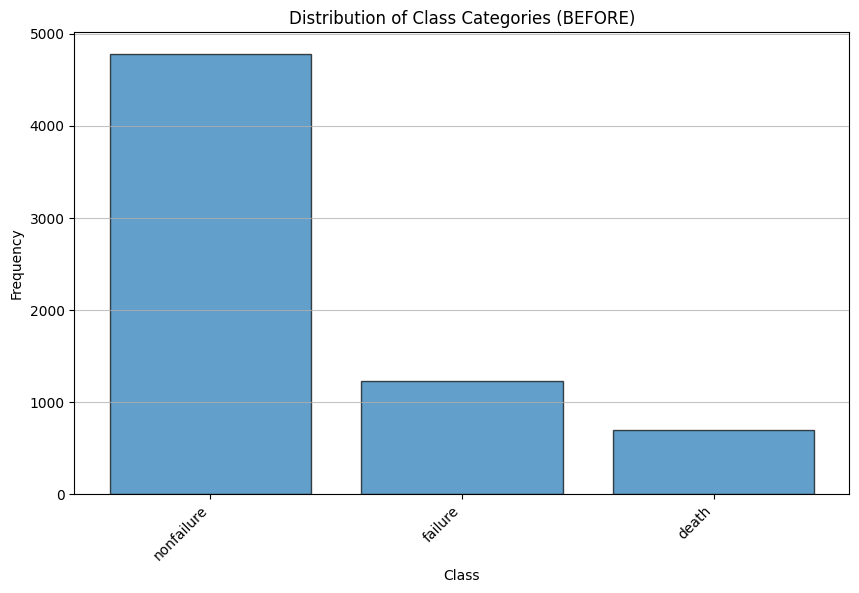

class
nonfailure    4778
failure       1232
death          699
Name: count, dtype: int64
TOTAL: 6709


In [39]:
# Class 별로 (Non-failure, Death, Failure) 빈도 확인
class_counts = subjects_df_original['class'].value_counts()

# bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, edgecolor='k', alpha=0.7)
plt.title('Distribution of Class Categories (BEFORE)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

print(class_counts)
print(f'TOTAL: {class_counts.sum()}')

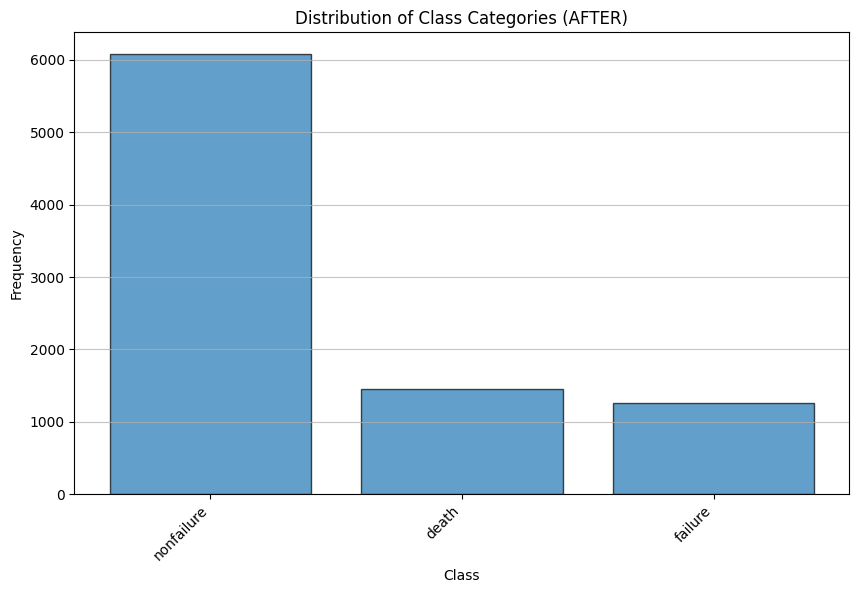

class
nonfailure    6078
death         1450
failure       1262
Name: count, dtype: int64
TOTAL: 8790


In [42]:
# Class 별로 (Non-failure, Death, Failure) 빈도 확인
class_counts = subjectlist1['class'].value_counts()

# bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, edgecolor='k', alpha=0.7)
plt.title('Distribution of Class Categories (AFTER)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

print(class_counts)
print(f'TOTAL: {class_counts.sum()}')

In [ ]:
# Class 별로 (Non-failure, Death, Failure) 빈도 확인
class_counts = subjects_df_original['class'].value_counts()

# bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, edgecolor='k', alpha=0.7)
plt.title('Distribution of Class Categories (BEFORE)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

print(class_counts)
print(f'TOTAL: {class_counts.sum()}')

In [38]:
subjectlist1.intubationtime.isna().sum(), subjectlist1.extubationtime.isna().sum()

(1143, 244)

In [35]:
subjectlist1[((subjectlist1.intext_duration.isna()) | (subjectlist1.intext_duration > 0)) &\
              ((subjectlist1.reintubationtime.isna()) | (subjectlist1.reintubationtime >= 0))]

,subject_id,hadm_id,stay_id,gender,los,int_stayid,admittime,intubationtime,int_itemid,int_weight,...,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stayid_mismatch
0,10001884,26184834,37510196,F,9.171817,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,...,NaN,NaN,False,True,10775.0,10775.0,0.0,11,nonfailure,False
1,10003400,23559586,38383343,F,16.069838,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,...,NaN,NaN,False,True,17365.0,17365.0,0.0,11,nonfailure,False
2,10004401,27939719,31202136,M,2.523519,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,...,NaN,NaN,False,True,NaN,151.0,NaN,121,nonfailure,False
3,10004401,29988601,32773003,M,10.636238,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,...,2144-01-30 13:00:00,30.0,False,False,NaN,10035.0,NaN,211,failure,False
4,10004401,29988601,32773003,NaN,NaN,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,...,NaN,NaN,False,True,NaN,0.0,NaN,2221,nonfailure,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,19997367,20617667,35616526,F,25.337569,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,...,2126-05-05 18:20:00,4430.0,False,False,NaN,24345.0,NaN,212,nonfailure,False
8996,19997367,20617667,35616526,F,25.337569,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,...,NaN,NaN,False,True,NaN,15646.0,NaN,221,nonfailure,False
8997,19999068,21606769,30143796,M,6.765324,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,...,NaN,NaN,False,True,NaN,7525.0,NaN,11,nonfailure,False
8998,19999442,26785317,32336619,M,6.950370,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,...,NaN,NaN,True,True,NaN,20290.0,NaN,11,nonfailure,False


In [ ]:
filtered_sl = subjectlist1[(subjectlist1.intext_duration >= 0)]
filtered_sl

### 7. Subject list 추출
- 개념정리:
    - 지금까지는 hadm_id 기준으로 intubation, extubation 데이터를 정리했음.
        - 정리된 데이터는 'subjectlist1_intextevents.csv', subjectlist2_intextevents.csv' 파일로 저장됨.
    - 순전히 subject list 만 있는 데이터는 'sub1list', 'sub2list'로 저장됨.
    - 이 둘의 차이는 '행' 수의 차이. 'subjectlist1_intextevents.csv', subjectlist2_intextevents.csv' 파일의 경우, 한 hadm_id 내에서 여러번의 삽관/발관이 있을 수 있기 때문에, 고유한 환자리스트보다 행수가 더 많음. 
    - 반면, 'sub1list', 'sub2list'는 순전히 환자번호(subject_id)와 입원정보(hadm_id, stay_id, admittime, dischtime)만 있기 때문에, 행수가 더 적음.
        - 즉, 고유한 환자 리스트 (unique patient list).
    - 따라서 Feature 결합 시에는 이 테이블을 활용하는 것이 맞음.

In [136]:
subjectlist1

,subject_id,hadm_id,stay_id,gender,los,int_stayid,admittime,intubationtime,int_itemid,int_weight,...,reintubation_eventtime,reintubationtime,mvtime,final_event,ext_to_death,ext_to_disch,disch_to_death,class_code,class,stayid_mismatch
0,10001884,26184834,37510196.0,F,9.171817,37510196.0,2131-01-07 20:39:00,2131-01-11 04:30:00,224385.0,65.0,...,NaN,NaN,False,True,10775.0,10775.0,0.0,11,nonfailure,False
1,10003400,23559586,38383343.0,F,16.069838,38383343.0,2137-08-04 00:07:00,2137-08-17 21:21:00,224385.0,90.5,...,NaN,NaN,False,True,17365.0,17365.0,0.0,11,nonfailure,False
2,10004401,27939719,31202136.0,M,2.523519,31202136.0,2144-04-11 03:31:00,2144-04-11 05:03:00,224385.0,120.0,...,NaN,NaN,False,True,NaN,151.0,NaN,121,nonfailure,False
3,10004401,29988601,32773003.0,M,10.636238,32773003.0,2144-01-23 07:58:00,2144-01-27 19:00:00,224385.0,76.0,...,2144-01-30 13:00:00,30.0,False,False,NaN,10035.0,NaN,211,failure,False
4,10004401,29988601,NaN,NaN,NaN,32773003.0,2144-01-23 07:58:00,2144-01-30 13:00:00,224385.0,76.0,...,NaN,NaN,False,True,NaN,0.0,NaN,2221,nonfailure,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8998,19997367,20617667,35616526.0,F,25.337569,35616526.0,2126-04-20 07:15:00,2126-04-26 20:14:00,224385.0,59.0,...,2126-05-05 18:20:00,4430.0,False,False,NaN,24345.0,NaN,212,nonfailure,False
8999,19997367,20617667,35616526.0,F,25.337569,35616526.0,2126-04-20 07:15:00,2126-05-05 18:20:00,224385.0,59.0,...,NaN,NaN,False,True,NaN,15646.0,NaN,221,nonfailure,False
9000,19999068,21606769,30143796.0,M,6.765324,30143796.0,2161-08-24 04:10:00,2161-08-25 15:34:00,224385.0,55.8,...,NaN,NaN,False,True,NaN,7525.0,NaN,11,nonfailure,False
9001,19999442,26785317,32336619.0,M,6.950370,32336619.0,2148-11-19 10:00:00,2148-11-19 19:00:00,224385.0,107.5,...,NaN,NaN,True,True,NaN,20290.0,NaN,11,nonfailure,False


In [137]:
# 데이터 저장
sub1list = subjectlist1 >> select('subject_id','hadm_id',\
                                  'stay_id', 'admittime', 'dischtime')
sub1list = sub1list.drop_duplicates(subset='stay_id')   # remove dup


sub2list = subjectlist2 >> select('subject_id','hadm_id',\
                                  'stay_id', 'admittime', 'dischtime')
sub2list = sub2list.drop_duplicates(subset='stay_id')   # remove dup


subjectlist1.to_csv('./data/subjectlist1_intextevents.csv')   # 삽관발관 포함
subjectlist2.to_csv('./data/subjectlist2_intextevents.csv')   # 삽관발관 포함
sub1list.to_csv('./data/sub1list.csv')   # 고유 환자리스트
sub2list.to_csv('./data/sub2list.csv')   # 고유 환자리스트



In [138]:
sub1list.shape

(6725, 5)

### 8. subject 데이터 요약

In [142]:
subject_count = sub1list.subject_id.nunique()   # 환자 수

print(f'UNIQUE SUBJECTS: {subject_count}')
print(subjectlist1.class_code.value_counts())
print(f'SUM: {subjectlist1.class_code.value_counts().sum()}')

UNIQUE SUBJECTS: 6259
class_code
11       3614
211      1089
221       991
1221      989
212       717
2221      375
9999      360
22221     354
121       259
998        95
1222       80
999        48
22222      32
Name: count, dtype: int64
SUM: 9003


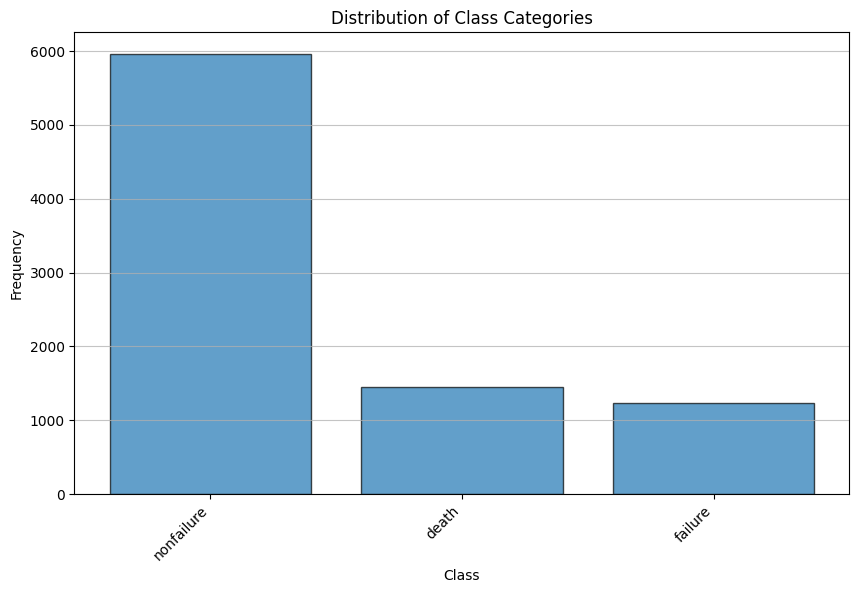

class
nonfailure    5956
death         1455
failure       1232
Name: count, dtype: int64
TOTAL: 8643


In [143]:
# Class 별로 (Non-failure, Death, Failure) 빈도 확인
class_counts = subjectlist1['class'].value_counts()

# bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values, edgecolor='k', alpha=0.7)
plt.title('Distribution of Class Categories')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()

print(class_counts)
print(f'TOTAL: {class_counts.sum()}')

In [144]:
sub1list

,subject_id,hadm_id,stay_id,admittime,dischtime
0,10001884,26184834,37510196.0,2131-01-07 20:39:00,2131-01-20 05:15:00
1,10003400,23559586,38383343.0,2137-08-04 00:07:00,2137-09-02 17:05:00
2,10004401,27939719,31202136.0,2144-04-11 03:31:00,2144-04-13 17:31:00
3,10004401,29988601,32773003.0,2144-01-23 07:58:00,2144-02-06 11:45:00
4,10004401,29988601,NaN,2144-01-23 07:58:00,2144-02-06 11:45:00
...,...,...,...,...,...
8996,19995595,21784060,34670930.0,2126-10-17 21:43:00,2126-11-12 17:35:00
8998,19997367,20617667,35616526.0,2126-04-20 07:15:00,2126-05-19 14:15:00
9000,19999068,21606769,30143796.0,2161-08-24 04:10:00,2161-09-02 19:00:00
9001,19999442,26785317,32336619.0,2148-11-19 10:00:00,2148-12-04 16:25:00


In [149]:
# 결측치 숫자 전후 비교
original_null_row_count = ((subjects_df_original.intubationtime.isna()) | (subjects_df_original.extubationtime.isna())).sum()
adjusted_null_row_count = ((subjectlist1.intubationtime.isna()) | (subjectlist1.extubationtime.isna())).sum()

print(f'BEFORE: {original_null_row_count}')
print(f'AFTER: {adjusted_null_row_count}')
print(f'DIFF: {original_null_row_count - adjusted_null_row_count}')

BEFORE: 3321
AFTER: 1387
DIFF: 1934
